<a href="https://colab.research.google.com/github/beastboy-93/projects/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
# !pip install torch torchvision matplotlib opencv-python

from google.colab import drive
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split

# Mount Google Drive
drive.mount('/content/drive')

# Paths and parameters
dataset_path = "/content/drive/MyDrive/footprints"
test_image_path = "/content/drive/MyDrive/test_fp/lion_1.jpg"
model_path = "/content/drive/MyDrive/best_footprint.pth"
img_size = 128
num_classes = 10
batch_size = 16
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels
class_labels = sorted(os.listdir(dataset_path))
label_to_index = {label: idx for idx, label in enumerate(class_labels)}

# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

# Custom Dataset
class FootprintDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        for label in class_labels:
            folder = os.path.join(root_dir, label)
            if os.path.isdir(folder):
                for file in os.listdir(folder):
                    self.samples.append((os.path.join(folder, file), label_to_index[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found: {img_path}")
        if self.transform:
            img = self.transform(img)
        return img, label

# Load dataset
dataset = FootprintDataset(dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Dataset loaded: {train_size} training samples, {test_size} testing samples")
print(class_labels)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * (img_size//8) * (img_size//8), 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
best_accuracy = 0.0
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / len(test_set)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Val Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved with accuracy: {accuracy:.4f}")

# Load best model
model.load_state_dict(torch.load(model_path))
model.eval()

# Prediction function
def predict_footprint(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Image not found.")
        return None, None

    img = cv2.resize(img, (img_size, img_size))
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        predicted_idx = torch.argmax(probs).item()
        confidence = probs[0][predicted_idx].item()

    return class_labels[predicted_idx], confidence

# Test on a sample image
def predict_from_image(image_file):
    predicted_label, confidence = predict_footprint(image_file)
    if predicted_label is not None:
        print(f"Predicted class: {predicted_label} with confidence: {confidence:.2f}")

# Run prediction
predict_from_image(test_image_path)


Mounted at /content/drive
Dataset loaded: 1320 training samples, 330 testing samples
['Bear', 'Bobcat', 'Deer', 'Fox', 'Horse', 'Lion', 'Mouse', 'Racoon', 'Squirrel', 'Wolf']
Epoch 1/50, Loss: 177.5388, Val Accuracy: 0.3515
Best model saved with accuracy: 0.3515
Epoch 2/50, Loss: 160.3509, Val Accuracy: 0.4667
Best model saved with accuracy: 0.4667
Epoch 3/50, Loss: 147.9354, Val Accuracy: 0.3727
Epoch 4/50, Loss: 137.1100, Val Accuracy: 0.4333
Epoch 5/50, Loss: 130.7829, Val Accuracy: 0.5667
Best model saved with accuracy: 0.5667
Epoch 6/50, Loss: 119.2557, Val Accuracy: 0.5636
Epoch 7/50, Loss: 112.1779, Val Accuracy: 0.5667
Epoch 8/50, Loss: 106.1713, Val Accuracy: 0.5576
Epoch 9/50, Loss: 99.5431, Val Accuracy: 0.5939
Best model saved with accuracy: 0.5939
Epoch 10/50, Loss: 95.2247, Val Accuracy: 0.6212
Best model saved with accuracy: 0.6212
Epoch 11/50, Loss: 90.8956, Val Accuracy: 0.6818
Best model saved with accuracy: 0.6818
Epoch 12/50, Loss: 85.3523, Val Accuracy: 0.6909
Best


📊 Classification Report:
              precision    recall  f1-score   support

        Bear       0.81      0.91      0.85        32
      Bobcat       0.84      0.93      0.88        28
        Deer       0.85      0.97      0.90        29
         Fox       0.89      0.67      0.76        24
       Horse       0.95      0.90      0.93        41
        Lion       0.73      0.83      0.78        36
       Mouse       0.85      0.87      0.86        38
      Racoon       0.83      0.61      0.70        33
    Squirrel       0.81      0.81      0.81        36
        Wolf       0.88      0.88      0.88        33

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.83       330
weighted avg       0.84      0.84      0.84       330

⚠️ 'val_accuracies' not found. Did you record it during training?


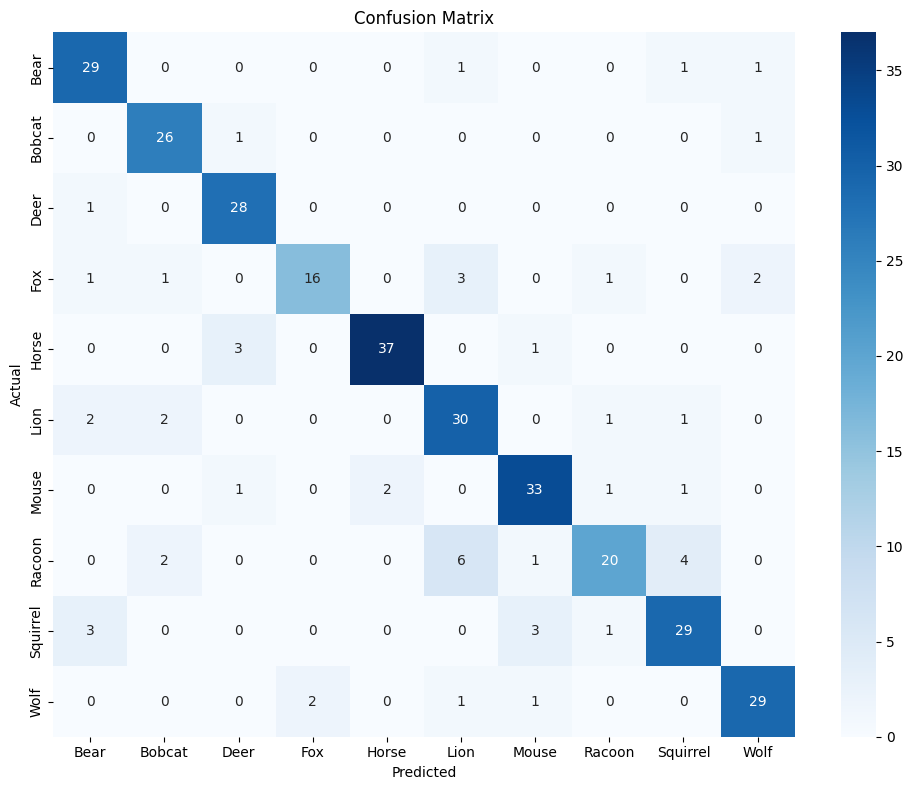

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reload best model
model.load_state_dict(torch.load(model_path))
model.eval()

# Evaluate and collect predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_labels))

# Plot accuracy
if 'val_accuracies' in globals():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.title("Validation Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'val_accuracies' not found. Did you record it during training?")

# Optional: Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
